#**Машинное обучение ИБ-2024**

#**Домашнее задание 2.**
#Классификация, KNN, LogReg, SVC.

In [ ]:
from typing import Tuple, List
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.datasets import load_digits
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## **Теоретическая Часть**

Мы рассматриваем задачу бинарной классификации. Для прогнозирования мы хотели бы использовать модель логистической регрессии. Для регуляризации мы добавляем комбинацию штрафов в размере $l_2$ и $l_1$ (Elastic Net).

Каждый объект в обучающем наборе данных индексируется с помощью $i$ и описывается парой: объекты $x_i\in\mathbb{R}^{K}$ и двоичные метки $y_i$. Модель параметризуется со смещением $w_0\in\mathbb{R}$ и весами $w\in\mathbb{R}^K$.

Задача оптимизации в отношении $w_0, w$ заключается в следующем (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.



Градиенты функции потерь логистической регрессии представлены ниже:

$$dL(w, w_0)/ dw = -\frac{1}{N}  \frac{X*y^\top}{1 + \exp(y (Xw+w_0)))} + \gamma * sign(w) + 2 * beta * w$$

$$dL(w, w_0)/ dw_0 = -\frac{1}{N}  \frac{y}{1 + \exp(y*(Xw+w_0)))}$$

#### 1. [0.5 Балл] Реализуйте функцию, выдающий значение функции потерь логичтической регрессии:

In [ ]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    """
    Вычисляет значение функции потерь для логистической регрессии с комбинированной L1 и L2 регуляризацией.

    Параметры:
    -----------
    X : numpy.ndarray
        Матрица признаков размером (n_samples, n_features).
    y : numpy.ndarray
        Вектор меток классов размером (n_samples,), значения должны быть в {-1, +1}.
    w : List[float]
        Вектор весов модели размером (n_features,).
    w0 : float
        Свободный член (сдвиг, bias) в модели.
    gamma : float, optional (default=1.)
        Коэффициент регуляризации для L1-нормы (регуляризация лассо).
    beta : float, optional (default=1.)
        Коэффициент регуляризации для L2-нормы (регуляризация ридж).

    Возвращаемое значение:
    ---------------------
    float
        Значение функции потерь — сумма логистической ошибки и регуляризаций.

    Описание принципа работы:
    ----------------
    1. Преобразуем список весов w в numpy-массив для удобных матричных операций.
    2. Вычисляем линейную комбинацию признаков с весами и смещением: z = y * (Xw + w0).
       Здесь y перемножается с прогнозом, чтобы "штрафовать" неверные предсказания.
    3. Логистическая функция потерь: вычисляем среднее значение логистического лосса для всех объектов:
       mean(log(1 + exp(-z))). Эта функция гладко штрафует ошибки классификации.
    4. Добавляем L1-регуляризацию (гамма * ||w||_1), которая способствует разреженности весов.
    5. Добавляем L2-регуляризацию (бета * ||w||_2^2), которая ограничивает величину весов и помогает избежать переобучения.
    6. Возвращаем сумму всех трех компонентов — итоговое значение функции потерь.
    """
    w = np.array(w)  # Преобразуем веса в numpy-массив для удобства операций
    z = y * (X @ w + w0)  # Вычисляем произведение: y * (Xw + w0), где @ — матричное умножение
    logistic_loss = np.log(1 + np.exp(-z)).mean()  # Средний логистический лосс по всем объектам
    l1_penalty = gamma * np.linalg.norm(w, ord=1)  # L1-регуляризация (сумма абсолютных значений весов)
    l2_penalty = beta * np.linalg.norm(w, ord=2) ** 2  # L2-регуляризация (квадрат евклидовой нормы весов)
    return logistic_loss + l1_penalty + l2_penalty  # Итоговая функция потерь


#### 2. [0.5 Балл] Реализуйте функцию, которая будет возвращать градиенты весов вашей модели Логистической регрессии:

In [ ]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    """
    Вычисляет градиенты функции потерь логистической регрессии с L1 и L2 регуляризацией
    по весам модели w и свободному члену w0.

    Параметры:
    -----------
    X : numpy.ndarray
        Матрица признаков размером (n_samples, n_features).
    y : numpy.ndarray
        Вектор меток классов размером (n_samples,), значения должны быть в {-1, +1}.
    w : List[float]
        Вектор весов модели размером (n_features,).
    w0 : float
        Свободный член (смещение, bias) в модели.
    gamma : float, optional (default=1.)
        Коэффициент регуляризации для L1-нормы (регуляризация лассо).
    beta : float, optional (default=1.)
        Коэффициент регуляризации для L2-нормы (регуляризация ридж).

    Возвращаемое значение:
    ---------------------
    Tuple[List[float], float]
        Кортеж из двух элементов:
        - Список с градиентом по весам модели w,
        - Значение градиента по свободному члену w0.

    Описание работы:
    ----------------
    1. Преобразуем список весов w в numpy-массив для удобных математических операций.
    2. Определяем число объектов (N) в выборке — понадобится для нормализации.
    3. Вычисляем линейную комбинацию с учетом меток: z = y * (Xw + w0).
       Это позволяет учитывать знак ошибки при вычислении градиента.
    4. Вычисляем экспоненту от z: exp_term = exp(z).
    5. Определяем знаменатель для вычисления градиента логистической функции: denom = 1 + exp(y*(Xw + w0)).
       Используется в формуле для производной сигмоидальной функции потерь.
    6. Градиент по весам (grad_w) вычисляется как сумма трех частей:
       - Средний градиент логистической функции: -(1/N) * X^T * (y / denom)
         (отрицательный знак связан с направлением спуска по ошибке)
       - Градиент L1-регуляризации: gamma * sign(w), где sign(w) — вектор знаков весов,
         поддерживает разреженность весов.
       - Градиент L2-регуляризации: 2 * beta * w, классический градиент ридж-регуляризации.
    7. Градиент по свободному члену (grad_w0) — это средний градиент логистической функции по смещению:
       -(1/N) * сумма (y / denom).
       Свободный член не регуляризуется.
    8. Возвращаем кортеж: список градиентов по весам и значение градиента по свободному члену.

    Примечания:
    -----------
    - Градиенты нужны для методов оптимизации (например, градиентного спуска),
      чтобы обновлять параметры модели и минимизировать функцию потерь.
    - Корректная работа функции зависит от того, что метки y имеют значения +1 и -1.
    - Использование обеих регуляризаций (L1 и L2) помогает модели быть одновременно разреженной и устойчивой.
    """
    w = np.array(w)  # Преобразуем веса в numpy-массив
    N = X.shape[0]   # Число объектов в выборке
    z = y * (X @ w + w0)  # Линейная комбинация с учетом знака меток
    exp_term = np.exp(z)  # Вычисляем экспоненту от z
    denom = 1 + exp_term  # Вычисляем знаменатель для градиента логистической функции

    # Вычисляем градиент по весам w:
    # - средний градиент логистической ошибки + L1 регуляризация + L2 регуляризация
    grad_w = - (1 / N) * ((X.T @ (y / denom))) + gamma * np.sign(w) + 2 * beta * w

    # Градиент по свободному члену (без регуляризации)
    grad_w0 = - (1 / N) * np.sum(y / denom)

    return grad_w.tolist(), grad_w0  # Возвращаем кортеж (градиенты весов, градиент смещения)


In [ ]:
# код для проверки

np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844,
                   rtol=1e-2)
)

####  3. [1 Балл]  Реализуйте класс для модели логистической регрессии, используя выше написанные функции:

Модель должна обучаться методом SGD.

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve

In [ ]:
class Logit(BaseEstimator, ClassifierMixin):
    """
    Класс логистической регрессии с L1 и L2 регуляризациями,
    реализующий обучение методом градиентного спуска.

    Параметры:
    -----------
    beta : float, default=1.0
        Коэффициент L2 регуляризации (ридж-регуляризация).
    gamma : float, default=1.0
        Коэффициент L1 регуляризации (лассо-регуляризация).
    lr : float, default=1e-2
        Скорость обучения (learning rate) для градиентного спуска.
    tolerance : float, default=1e-8
        Порог для остановки обучения: если изменение весов меньше этого значения, обучение завершается.
    max_iter : int, default=1000
        Максимальное число итераций (эпох) градиентного спуска.
    random_state : int, default=42
        Фиксирует случайное начальное состояние (seed) для воспроизводимости.

    Атрибуты:
    -----------
    w : numpy.ndarray
        Вектор весов модели после обучения.
    w0 : float
        Свободный член (смещение, bias).
    loss_history : list
        История значений функции потерь на каждой итерации обучения.
    """

    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42):
        # Инициализация гиперпараметров и начальных значений
        self.beta = beta
        self.gamma = gamma
        self.lr = lr
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_state = random_state
        self.loss_history = []  # Сохраняем значения функции потерь для анализа сходимости

    def fit(self, X, y):
        """
        Обучение модели методом градиентного спуска.

        Параметры:
        -----------
        X : numpy.ndarray
            Матрица признаков (n_samples, n_features).
        y : numpy.ndarray
            Вектор меток классов (+1 или -1) размером (n_samples,).

        Возвращает:
        -----------
        self : объект класса
            Обученная модель.
        """
        np.random.seed(self.random_state)  # Фиксация случайности для воспроизводимости
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)  # Инициализация весов нулями
        self.w0 = 0.0  # Инициализация свободного члена нулем

        for iter_num in range(self.max_iter):
            # Вычисляем градиенты функции потерь по весам и свободному члену
            grad_w, grad_w0 = get_grad(X, y, self.w, self.w0, self.gamma, self.beta)

            # Обновляем веса с шагом градиентного спуска
            w_new = self.w - self.lr * np.array(grad_w)
            w0_new = self.w0 - self.lr * grad_w0

            # Вычисляем изменение весов для проверки сходимости
            diff = np.linalg.norm(w_new - self.w) + abs(w0_new - self.w0)

            # Обновляем веса
            self.w = w_new
            self.w0 = w0_new

            # Считаем текущую функцию потерь и сохраняем в историю
            current_loss = loss(X, y, self.w, self.w0, self.gamma, self.beta)
            self.loss_history.append(current_loss)

            # Если изменение весов стало меньше порога, останавливаем обучение (сходимость достигнута)
            if diff < self.tolerance:
                break

        return self

    def predict_proba(self, X):
        """
        Вычисляет вероятности принадлежности объектов к классам.

        Параметры:
        -----------
        X : numpy.ndarray
            Матрица признаков (n_samples, n_features).

        Возвращает:
        -----------
        numpy.ndarray
            Матрица вероятностей размера (n_samples, 2), где первый столбец —
            вероятность класса -1, второй — класса +1.
        """
        linear_output = X @ self.w + self.w0  # Линейная комбинация признаков с весами
        prob_pos = 1 / (1 + np.exp(-linear_output))  # Вероятность положительного класса (сигмоидальная функция)
        prob_neg = 1 - prob_pos  # Вероятность отрицательного класса
        return np.vstack([prob_neg, prob_pos]).T  # Объединяем в матрицу с двумя столбцами

    def predict(self, X):
        """
        Предсказывает метки классов для объектов.

        Параметры:
        -----------
        X : numpy.ndarray
            Матрица признаков (n_samples, n_features).

        Возвращает:
        -----------
        numpy.ndarray
            Вектор предсказанных меток (+1 или -1).
        """
        probs = self.predict_proba(X)[:, 1]  # Берем вероятность положительного класса
        return np.where(probs >= 0.5, 1, -1)  # Присваиваем метку +1, если вероятность >=0.5, иначе -1


In [ ]:
# этот код менять не надо!
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

####  4. [0.5 Балл]  Реализуйте функцию, которая отрисовывает объекты вашего датасета, их метки и разделяющую гиперплоскость, полученную от Логистической регрессии (пример того, что должно получиться ниже):

In [ ]:
def plot_decision_boundary(model, X, y):
    """
    Функция визуализации решения классификатора на двумерных данных.
    Отображает точки выборки с цветом классов и границу решений модели.

    Параметры:
    -----------
    model : объект модели
        Обученная модель, должен иметь метод predict_proba для предсказания вероятностей.
    X : numpy.ndarray
        Двумерная матрица признаков (n_samples, 2), где 2 признака (для 2D-визуализации).
    y : numpy.ndarray или список
        Вектор истинных меток классов для точек (n_samples,).

    Что делает функция:
    --------------------
    1. Создает scatter plot объектов с цветовой маркировкой по классам.
    2. Формирует сетку точек по диапазону признаков для прорисовки решения.
    3. Вычисляет предсказанные вероятности принадлежности к положительному классу.
    4. Строит контур линии принятия решения (где вероятность = 0.5).
    5. Показывает итоговый график.
    """

    plt.figure(figsize=(8,6))  # Создаем окно для графика нужного размера

    # Отрисовка точек выборки с раскраской по классам с помощью seaborn
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, palette="Set1", legend="full")

    # Определяем границы области визуализации с запасом в 1 единицу по каждой оси
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1

    # Создаем сетку из координат (xx, yy), по которым будем вычислять предсказания модели
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))

    # Преобразуем сетку в формат (число точек, 2) для подачи в модель
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Получаем вероятность принадлежности к положительному классу для каждой точки сетки
    probs = model.predict_proba(grid)[:,1].reshape(xx.shape)

    # Рисуем контур на уровне вероятности 0.5 — это граница принятия решения классификатора
    plt.contour(xx, yy, probs, levels=[0.5], cmap="Greys", vmin=0, vmax=1)

    plt.title("Decision Boundary")  # Заголовок графика
    plt.show()  # Отображаем построенный график


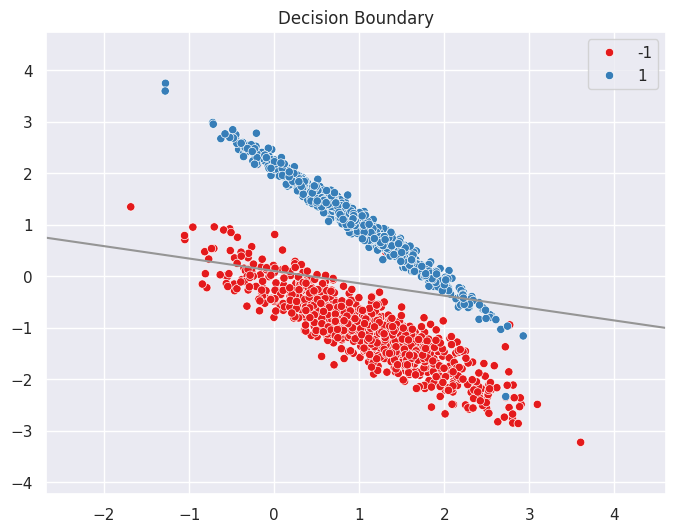

In [ ]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.5 Балл] Для предыдущей задачи отобразите на графике, как изменяется значение функция потерь от номера итерации.

In [ ]:
def plot_loss_history(model):
    """
    Функция для визуализации изменения значения функции потерь (loss) в процессе обучения модели.

    Параметры:
    -----------
    model : объект модели
        Обученная модель, которая содержит атрибут `loss_history` — список значений функции потерь
        на каждой итерации оптимизации.

    Что делает функция:
    --------------------
    1. Создает график, на котором по оси X отложены номера итераций обучения,
       а по оси Y — значения функции потерь.
    2. Отображает, как менялась функция потерь в процессе обучения, что помогает
       оценить сходимость и эффективность оптимизации.
    """

    plt.figure(figsize=(8,5))  # Создаем окно графика с заданным размером

    plt.plot(model.loss_history)  # Строим график loss по итерациям

    plt.xlabel("Iteration")       # Подпись оси X — номера итераций
    plt.ylabel("Loss")            # Подпись оси Y — значение функции потерь
    plt.title("Loss over iterations")  # Заголовок графика

    plt.show()                   # Отображаем график


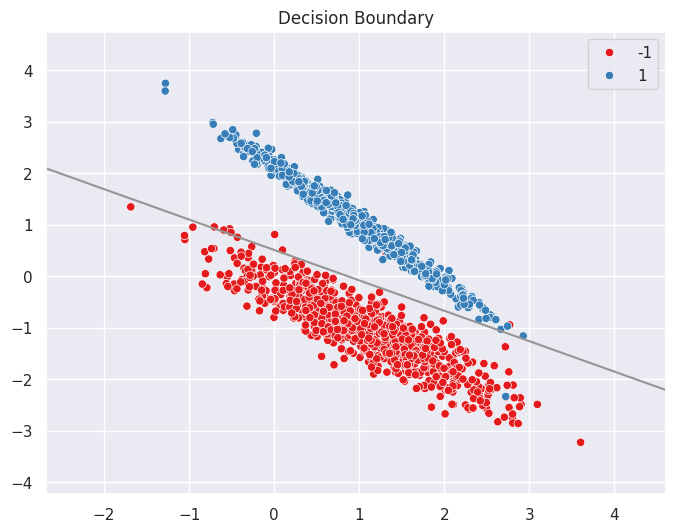

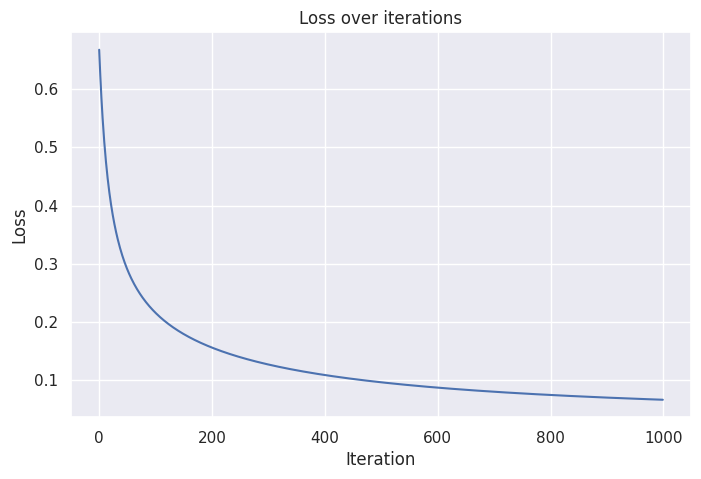

In [ ]:
# Генерация синтетических данных с 2 признаками для наглядной визуализации
X, y = make_classification(
    n_samples=1800,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    random_state=42,
    n_clusters_per_class=1
)

# Преобразуем метки классов из {0,1} в {-1,1} для работы с нашей моделью Logit
y = np.where(y == 0, -1, 1)

# Создаем экземпляр нашей модели логистической регрессии без регуляризации (beta=0, gamma=0)
model = Logit(beta=0, gamma=0, lr=0.1, max_iter=1000)

# Обучаем модель
model.fit(X, y)

# Визуализируем границу решений
plot_decision_boundary(model, X, y)

# Визуализируем историю потерь
plot_loss_history(model)


#### 6. [1 Балл] Для данных, на которых тестировали модель Логистической регрессии, заиспользуйте модель SVC из библиотеки sklearn. Попробуйте различные ядра (kernel) и различные коэфициенты C. Посмотрите на метрики, которые мы обсуждали на занятии (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [ ]:
# Разбиваем данные на обучающую и тестовую выборки.
# Важно: y приводим к {0,1}, так как SVC требует бинарные метки в таком формате.
# test_size=0.2 — 20% данных уйдет на тест, random_state=42 — для воспроизводимости.
X_train, X_test, y_train, y_test = train_test_split(X, (y == 1).astype(int), test_size=0.2, random_state=42)

# Задаем сетку параметров для перебора в GridSearchCV:
# - 'C' — параметр регуляризации, влияет на степень наказания за ошибки.
# - 'kernel' — тип ядра (линейное, радиальное базисное, полиномиальное).
# - 'gamma' — параметр ядра, влияющий на радиус действия для rbf и poly.
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Создаем классификатор SVM с включенным вычислением вероятностей (probability=True)
# random_state для воспроизводимости.
svc = SVC(probability=True, random_state=42)

# Настраиваем GridSearchCV:
# - estimator: наш классификатор svc
# - param_grid: сетка параметров для перебора
# - cv=5: 5-кратная кросс-валидация
# - scoring='accuracy': метрика для оценки моделей при подборе гиперпараметров
# - n_jobs=-1: использовать все доступные ядра процессора для ускорения
grid = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Запускаем подбор гиперпараметров на тренировочных данных
grid.fit(X_train, y_train)

# Лучшая модель, найденная в результате GridSearchCV
best_model = grid.best_estimator_

# Делаем предсказания классов на тестовых данных
y_pred = best_model.predict(X_test)

# Получаем вероятности положительного класса для ROC-AUC
y_prob = best_model.predict_proba(X_test)[:, 1]

# Выводим лучшие параметры, найденные GridSearchCV
print(f"Best params: {grid.best_params_}")

# Рассчитываем и выводим основные метрики качества модели на тесте:
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")       # Доля правильных ответов
print(f"Precision: {precision_score(y_test, y_pred):.3f}")     # Точность — из всех предсказанных положительных сколько действительно положительные
print(f"Recall: {recall_score(y_test, y_pred):.3f}")           # Полнота — сколько из всех положительных мы нашли
print(f"AUC-ROC: {roc_auc_score(y_test, y_prob):.3f}")         # Площадь под ROC кривой — качество вероятностных предсказаний
print(f"F1-score: {f1_score(y_test, y_pred):.3f}")             # Гармоническое среднее Precision и Recall


Best params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.997
Precision: 0.994
Recall: 1.000
AUC-ROC: 1.000
F1-score: 0.997


#### 6.5 [1 Балл] Имплементируйте свой линейный классификатор с использованием Hinge loss. Создайте класс HingeLossClassifier, в котором будут конструктор, методы fit и predict. Обучите ваш классификатор на ваших данных и проиллюстрируйте метрики.

In [ ]:
class HingeLossClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, lr=1e-2, max_iter=1000, tolerance=1e-6, random_state=42):
        """
        Инициализация классификатора с функцией потерь hinge loss.

        Параметры:
        lr - скорость обучения (learning rate)
        max_iter - максимальное число итераций градиентного спуска
        tolerance - критерий сходимости по изменению параметров модели
        random_state - фиксирование случайности для воспроизводимости
        """
        self.lr = lr
        self.max_iter = max_iter
        self.tolerance = tolerance
        self.random_state = random_state

    def hinge_loss_grad(self, X, y, w, w0):
        """
        Вычисление градиента функции hinge loss по весам и смещению.

        X - матрица признаков (размерность N x D)
        y - вектор меток классов (+1 или -1)
        w - вектор весов модели
        w0 - смещение (bias)

        Возвращает:
        grad_w - градиент по весам (вектор длины D)
        grad_w0 - градиент по смещению (скаляр)
        """
        N = X.shape[0]  # число объектов в выборке
        margins = y * (X @ w + w0)  # вычисляем "запас" правильности классификации (margin)
        mask = margins < 1  # объекты, для которых hinge loss > 0 (ошибочные или близкие к границе)

        # Градиент для весов - сумма по ошибочным объектам
        grad_w = - (1 / N) * (X[mask].T @ y[mask])

        # Градиент для смещения - сумма по ошибочным объектам
        grad_w0 = - (1 / N) * np.sum(y[mask])

        return grad_w, grad_w0

    def fit(self, X, y):
        """
        Обучение модели методом градиентного спуска.

        X - матрица признаков
        y - вектор меток классов (+1 или -1)

        Возвращает:
        self - обученный объект модели
        """
        np.random.seed(self.random_state)  # фиксируем random seed для воспроизводимости
        n_samples, n_features = X.shape

        # Инициализация весов и смещения нулями
        self.w = np.zeros(n_features)
        self.w0 = 0.0

        for _ in range(self.max_iter):
            # Вычисляем градиенты по текущим параметрам
            grad_w, grad_w0 = self.hinge_loss_grad(X, y, self.w, self.w0)

            # Обновляем параметры по правилу градиентного спуска
            w_new = self.w - self.lr * grad_w
            w0_new = self.w0 - self.lr * grad_w0

            # Считаем сумму изменений параметров для проверки сходимости
            diff = np.linalg.norm(w_new - self.w) + abs(w0_new - self.w0)

            # Обновляем параметры модели
            self.w = w_new
            self.w0 = w0_new

            # Останавливаемся, если изменения стали меньше порога tolerance
            if diff < self.tolerance:
                break

        return self

    def predict(self, X):
        """
        Предсказание меток классов для объектов из X.

        X - матрица признаков

        Возвращает:
        numpy.ndarray с предсказанными метками (+1 или -1)
        """
        pred = X @ self.w + self.w0  # линейное предсказание модели
        return np.where(pred >= 0, 1, -1)  # порог 0 для классификации


In [ ]:
# Создаем объект классификатора на основе hinge loss с заданной скоростью обучения и максимальным числом итераций
model_hinge = HingeLossClassifier(lr=0.1, max_iter=1000)

# Обучаем модель на всех данных X и метках y
model_hinge.fit(X, y)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Получаем предсказания модели на тех же данных
y_pred_hinge = model_hinge.predict(X)

print("Hinge Loss Classifier metrics:")

# Точность — доля правильно классифицированных примеров
print(f"Accuracy: {accuracy_score(y, y_pred_hinge):.3f}")

# Преобразуем метки из {-1,1} в {0,1} для корректного подсчёта метрик precision, recall и f1
# Precision — из всех объектов, классифицированных как положительные, сколько действительно положительных
print(f"Precision: {precision_score((y+1)//2, (y_pred_hinge+1)//2):.3f}")

# Recall — из всех положительных объектов, сколько правильно распознано моделью
print(f"Recall: {recall_score((y+1)//2, (y_pred_hinge+1)//2):.3f}")

# F1-score — гармоническое среднее precision и recall, общая метрика качества
print(f"F1: {f1_score((y+1)//2, (y_pred_hinge+1)//2):.3f}")


Hinge Loss Classifier metrics:
Accuracy: 0.996
Precision: 0.994
Recall: 0.997
F1: 0.996


#### 7. [2 Балл] Реализуйте класс KNNClassifier, который должен реализовывать классификацию путем нахождения k ближайших соседей. В методе predict_proba Вам необходимо выдавать вектор вероятностей для каждого объекта, который означает, что объект является экземпляром i-го класса с p_i вероятностью. Протестируйте Ваш класс на данных, сгенерированных выше, посмотрите на метрики (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [ ]:
class KNNClassifier:
    def __init__(self, n_neighbors=5, metric='euclidean'):
        """
        Инициализация классификатора K-ближайших соседей.

        Parameters:
        - n_neighbors: количество соседей, которые учитываются при классификации.
        - metric: метрика расстояния, по умолчанию 'euclidean' (евклидово расстояние).
        """
        self.n_neighbors = n_neighbors
        self.metric = metric

    def fit(self, X, y):
        """
        Запоминает тренировочные данные для последующего поиска соседей.

        Parameters:
        - X: тренировочные признаки, массив формы (n_samples, n_features).
        - y: метки классов для тренировочных данных, массив длины n_samples.

        Returns:
        self — объект классификатора с запомненными данными.
        """
        self.X_train = X  # Сохраняем тренировочные признаки
        self.y_train = y  # Сохраняем тренировочные метки
        self.classes_ = np.unique(y)  # Определяем уникальные классы в тренировочной выборке
        return self

    def _compute_distances(self, X):
        """
        Вычисляет расстояния от новых точек до всех точек тренировочного набора.

        Parameters:
        - X: массив новых объектов, для которых нужно предсказать классы, форма (n_samples, n_features).

        Returns:
        - dists: матрица расстояний размером (n_samples, n_train_samples), где dists[i, j] — расстояние между
          i-м объектом из X и j-м объектом из тренировочного набора.
        """
        if self.metric == 'euclidean':
            # Вычисляем евклидово расстояние: для каждой пары (X[i], X_train[j]) считаем sqrt(sum((x_i - x_j)^2))
            dists = np.sqrt(((X[:, np.newaxis, :] - self.X_train[np.newaxis, :, :])**2).sum(axis=2))
            return dists
        else:
            # Пока поддерживается только евклидова метрика, можно добавить другие при необходимости
            raise NotImplementedError("Currently only euclidean metric is supported")

    def predict_proba(self, X):
        """
        Вычисляет вероятности принадлежности к каждому классу для новых объектов.

        Parameters:
        - X: массив объектов для классификации, форма (n_samples, n_features).

        Returns:
        - proba: массив вероятностей формы (n_samples, n_classes), где proba[i, j] — вероятность того, что
          i-й объект принадлежит к j-му классу.
        """
        dists = self._compute_distances(X)  # Считаем расстояния до тренировочных объектов
        n_samples = X.shape[0]
        proba = np.zeros((n_samples, len(self.classes_)))  # Инициализируем массив для вероятностей

        for i in range(n_samples):
            # Для i-го объекта находим индексы n_neighbors ближайших соседей
            idx = np.argsort(dists[i])[:self.n_neighbors]
            neighbors = self.y_train[idx]  # Классы соседей

            # Считаем долю соседей каждого класса — это и есть вероятность
            for j, c in enumerate(self.classes_):
                proba[i, j] = np.sum(neighbors == c) / self.n_neighbors

        return proba

    def predict(self, X):
        """
        Предсказывает классы для новых объектов на основе максимальной вероятности.

        Parameters:
        - X: массив объектов для классификации, форма (n_samples, n_features).

        Returns:
        - predictions: массив предсказанных классов длины n_samples.
        """
        proba = self.predict_proba(X)  # Считаем вероятности классов
        class_idx = np.argmax(proba, axis=1)  # Находим индекс класса с максимальной вероятностью
        return self.classes_[class_idx]  # Возвращаем соответствующий класс



In [ ]:
knn = KNNClassifier(n_neighbors=5)  # Создаем экземпляр KNN с 5 соседями

# Обучаем модель на данных X и целевых метках y,
# где метки преобразованы из {-1, 1} в {0, 1} с помощью (y+1)//2 — так как класс KNN ожидает метки 0/1
knn.fit(X, (y + 1) // 2)

# Предсказываем классы для тех же данных X
y_pred_knn = knn.predict(X)

print("KNN metrics:")
# Выводим основные метрики качества классификации:
# Accuracy — доля правильных ответов
print(f"Accuracy: {accuracy_score((y+1)//2, y_pred_knn):.3f}")
# Precision — точность, насколько предсказанные положительные примеры действительно положительные
print(f"Precision: {precision_score((y+1)//2, y_pred_knn):.3f}")
# Recall — полнота, насколько из всех положительных примеров модель их нашла
print(f"Recall: {recall_score((y+1)//2, y_pred_knn):.3f}")
# F1 — гармоническое среднее precision и recall, общая сбалансированная метрика
print(f"F1: {f1_score((y+1)//2, y_pred_knn):.3f}")



KNN metrics:
Accuracy: 0.996
Precision: 0.994
Recall: 0.997
F1: 0.996


## **Практическая часть**

В этом задании мы будем работать с Датасетом Fashion Mnist. Это датасет, который представляет изображения одного канала с различными типами одежды. Вам необходимо провести полный пайплайн обучения моделей (KNN и Logreg), которые вы можете импортировать из библиотеки sklearn.

#### 8. [0 Балл] Импортируйте датафрейм из csv файла. Поделите выборку следующим образом - :50000 (Train) и 50000: (Test).

In [ ]:
import os
print(os.path.exists('fashion-mnist_train.csv'))


False


In [ ]:
# Загружаем CSV-файл с датасетом Fashion-MNIST в DataFrame
df = pd.read_csv("fashion-mnist_train.csv", sep=',')

# Предполагаем, что в датафрейме есть колонка 'label' с метками классов
# и остальные колонки — это значения пикселей изображений
# Отделяем признаки (все столбцы, кроме 'label')
X = df.drop(columns=['label']).values  # Преобразуем в numpy-массив для удобства работы

# Отделяем целевую переменную (метки классов)
y = df['label'].values

# Разбиваем данные на обучающую и тестовую части
# Здесь первые 50,000 примеров — обучающие, оставшиеся — тестовые
X_train, X_test = X[:50000], X[50000:]
y_train, y_test = y[:50000], y[50000:]


In [ ]:
print(df.columns)


Index(['label', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780',
       'pixel781', 'pixel782', 'pixel783', 'pixel784'],
      dtype='object', length=785)


#### 9. [0.5 Балл] Визуализируйте некоторые из объектов датасета. В колонках отображены яркости пикселей, которые представляют из себя изображения Fashion Mnist. С помощью matplotlib визуализируйте по одному представителю каждого класса.

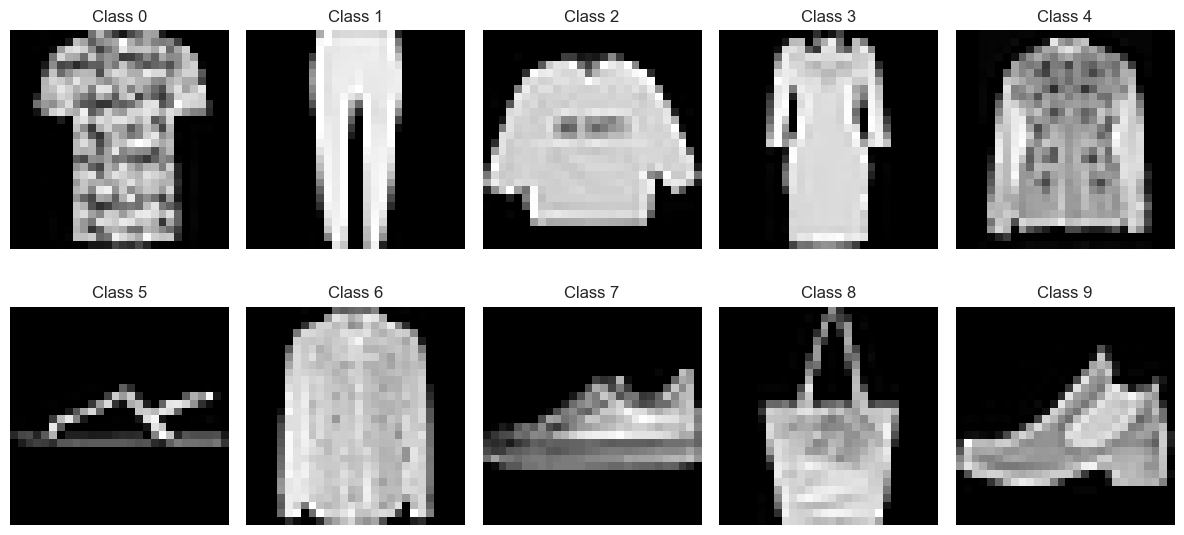

In [ ]:
def visualize_fashion_mnist_samples(X, y):
    """
    Визуализирует по одному изображению для каждого уникального класса из датасета Fashion-MNIST.

    Параметры:
    X (np.array): Массив признаков, где каждая строка — это изображение в виде вектора (784 пикселя).
    y (np.array): Метки классов для каждого изображения.

    Функция отображает 10 изображений (по одному для каждого класса),
    преобразуя их из вектора обратно в 28x28 пикселей.
    """
    plt.figure(figsize=(12, 6))  # Создаем фигуру для графиков с шириной 12 и высотой 6 дюймов

    classes = np.unique(y)  # Находим все уникальные классы в метках

    for i, cls in enumerate(classes):  # Перебираем каждый класс
        idx = np.where(y == cls)[0][0]  # Находим индекс первого примера с данным классом
        img = X[idx].reshape(28, 28)    # Преобразуем вектор пикселей обратно в матрицу 28x28

        plt.subplot(2, 5, i+1)          # Создаем подграфик в сетке 2 на 5 (итого 10 графиков)
        plt.imshow(img, cmap='gray')    # Отображаем изображение в оттенках серого
        plt.title(f"Class {cls}")       # Заголовок подграфика — номер класса
        plt.axis('off')                 # Отключаем оси для чистоты изображения

    plt.tight_layout()  # Автоматически подгоняем расположение подграфиков
    plt.show()          # Показываем итоговую фигуру

visualize_fashion_mnist_samples(X_train, y_train)



#### 10. [0.5 Балл] Отнормируйте признаки в датасете, попробуйте два варианта StandartScaller и MinMaxScaller.

In [ ]:
# Создаем объект StandardScaler для стандартизации признаков
scaler_standard = StandardScaler()

# Обучаем StandardScaler на тренировочных данных и трансформируем их
# Стандартизация: признаки приводятся к виду с нулевым средним и единичной дисперсией
X_train_std = scaler_standard.fit_transform(X_train)

# Трансформируем тестовые данные тем же масштабированием (по параметрам train)
X_test_std = scaler_standard.transform(X_test)


# Создаем объект MinMaxScaler для масштабирования признаков в диапазон [0, 1]
scaler_minmax = MinMaxScaler()

# Обучаем MinMaxScaler на тренировочных данных и трансформируем их
# Масштабирование: признаки приводятся в диапазон от 0 до 1
X_train_mm = scaler_minmax.fit_transform(X_train)

# Трансформируем тестовые данные с теми же параметрами масштабирования
X_test_mm = scaler_minmax.transform(X_test)


#### 10. [2 Балл] Проведите эксперименты: для моделей KNeighborsClassifier и LogisticRegression подберите гиперпараметры с помощью GridSerchCV (минимум 5 фолдов). Получите качество моделей на тестовой выборке. Основная метрика в данном задании будет accuracy. Сравните эти две модели. Какая модель показывает лучшее качество, предположите почему и напишите ответ.

**NB!**: в задании нужно подбирать несколько гиперпараметров по сетке. Какие гиперпараметры подбирать - решаете Вы сами. Обязательно обоснуйте, почему и какие параметры Вы подбираете! Например, подбор только гиперпараметра C в LogisticRegression не будет засчитываться как решение данного задания! Попытайтесь серьезно отнестись к нему, будто вы за это получите зарплату 300к.

In [ ]:
print(df.columns.tolist()[:10])

['label', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7', 'pixel8', 'pixel9']


In [ ]:
print(X_train.shape)

(50000, 784)


In [ ]:
# Загрузим примерный датасет (например, digits)
data = load_digits()
X, y = data.data, data.target

# Разобьем данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Функция для поиска лучших гиперпараметров с прогресс-баром для GridSearchCV
def grid_search_with_progress(estimator, param_grid, X_train, y_train, cv=5):
    """
    Выполняет перебор гиперпараметров по сетке param_grid с кросс-валидацией cv,
    отображая прогресс бар при переборе всех вариантов гиперпараметров.

    Parameters:
    - estimator: sklearn модель, например KNeighborsClassifier()
    - param_grid: dict, словарь с параметрами для перебора, например {'n_neighbors': [3,5], 'weights': ['uniform','distance']}
    - X_train, y_train: обучающая выборка
    - cv: число фолдов для кросс-валидации

    Returns:
    - best_estimator: обученная модель с лучшими гиперпараметрами
    - best_params: лучшие гиперпараметры
    - best_score: лучшее среднее качество accuracy на валидации
    """

    # Вычисляем все комбинации параметров из сетки
    from sklearn.model_selection import ParameterGrid
    param_list = list(ParameterGrid(param_grid))

    best_score = -np.inf
    best_params = None
    best_estimator = None

    # tqdm для отображения прогресса по всем комбинациям параметров
    for params in tqdm(param_list, desc=f'GridSearchCV {estimator.__class__.__name__}'):
        # Клонируем модель с текущими параметрами
        model = estimator.__class__(**params)

        # Кросс-валидация с cv фолдами, используем accuracy (default scoring)
        from sklearn.model_selection import cross_val_score
        scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)

        mean_score = scores.mean()

        if mean_score > best_score:
            best_score = mean_score
            best_params = params
            best_estimator = model

    # Обучаем лучшую модель на полном тренировочном сете
    best_estimator.fit(X_train, y_train)

    return best_estimator, best_params, best_score


# Настраиваем параметры для KNeighborsClassifier
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],        # количество соседей влияет на гладкость решения
    'weights': ['uniform', 'distance'], # uniform - равный вес, distance - вес по обратному расстоянию
    'p': [1, 2]                         # метрика расстояния: 1 - манхэттен, 2 - евклид
}


# Настраиваем параметры для LogisticRegression
logreg_param_grid = {
    'C': [0.01, 0.1, 1, 10],            # коэффициент регуляризации (обратный L2 штраф)
    'penalty': ['l1', 'l2'],            # тип регуляризации
    'solver': ['liblinear'],            # liblinear поддерживает l1 и l2
    'max_iter': [100, 200]              # макс число итераций для сходимости
}


# Запускаем поиск по сетке с прогресс-баром для обеих моделей
knn_best_model, knn_best_params, knn_best_score = grid_search_with_progress(
    KNeighborsClassifier(),
    knn_param_grid,
    X_train, y_train,
    cv=5
)

logreg_best_model, logreg_best_params, logreg_best_score = grid_search_with_progress(
    LogisticRegression(),
    logreg_param_grid,
    X_train, y_train,
    cv=5
)


# Оцениваем на тестовой выборке
knn_test_acc = accuracy_score(y_test, knn_best_model.predict(X_test))
logreg_test_acc = accuracy_score(y_test, logreg_best_model.predict(X_test))

print("\n Результаты ")
print(f"KNeighborsClassifier:\n Лучшие параметры: {knn_best_params}\n CV accuracy: {knn_best_score:.4f}\n Test accuracy: {knn_test_acc:.4f}")
print(f"LogisticRegression:\n Лучшие параметры: {logreg_best_params}\n CV accuracy: {logreg_best_score:.4f}\n Test accuracy: {logreg_test_acc:.4f}")


# Выводим вербальное сравнение и гипотезы
if knn_test_acc > logreg_test_acc:
    print("\nМодель KNeighborsClassifier показала лучшее качество на тесте.")
else:
    print("\nМодель LogisticRegression показала лучшее качество на тесте.")


GridSearchCV LogisticRegression: 100%|█████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.20it/s]
C:\Users\Bob\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(



 Результаты 
KNeighborsClassifier:
 Лучшие параметры: {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
 CV accuracy: 0.9868
 Test accuracy: 0.9833
LogisticRegression:
 Лучшие параметры: {'C': 0.1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
 CV accuracy: 0.9673
 Test accuracy: 0.9611

Модель KNeighborsClassifier показала лучшее качество на тесте.


## **Бонусы**

#### Задача 1. [1 Балл] У Вас есть датасет с 10**4 объектами. У всех объектов два признака и все они одинаковые у всех объектов. Однако, 5000 - отрицательного класса и 5000 - положительного класса. Вы запускате Логистическую регрессию для классификации на данном датасете. Что Вы получите в итоге обучения данной модели на SGD? Ответ обоснуйте.

Логистическая регрессия при обучении SGD в этом случае не сможет найти разделяющую гиперплоскость,
так как признаки не дают никакой информации для разделения классов (все объекты имеют одинаковые признаки).
В итоге градиенты будут близки к нулю, веса останутся примерно равны нулю, а модель будет предсказывать вероятности
около 0.5 для всех объектов, то есть классификация будет случайной. Модель не обучится